# HWRS640 - Assignment 2: Regression, ODE solvers, and optimization

## Due date: Friday, February 23rd at 11:59 PM

In [ ]:
import numpy as np
import matplotlib.pyplot as plt 
import pandas as pd 
import sklearn as skl 
from scipy import interpolate
from scipy.integrate import solve_ivp
import spotpy

## Problem 1: Shuffled complex evolution (SCE) optimization (25 points)
Read the original paper by Duan et al. (1992) on the Shuffled Complex Evolution (SCE) optimization algorithm (https://doi.org/10.1007/BF00939380). 

Summarize the main steps of the SCE algorithm in your own words. 
- The SCE algorithm uses strategies of random search, clustering, evolving search points within clusters, ranking and comparison of results between clusters to identify a minimum / solution. A population of sample points is generated and split into multiple complexes (clusters of subgroups from the population). Each complex is randomly sampled within a region of the solution spaced, the value for each sample point is computed and ranked within each complex. This is continued and and complexes are seperately evolved in sampling directions according to their outcomes and ranking until a condition is reached where shuffling occurs. During shuffling, points are mixed amongst complexes, where subcomplexes of points are used to generate "offspring" or new points based on the information generated between parent points using the Nelder Mead method. Mutations of random points are also involved. This process iteratively cycles until a stopping condition is reached. 


Discuss the problems that the SCE algorithm is designed to solve
- SCE is designed to solve problems which have output spaces that have many sporadic areas of local minima solutions, where there could be a non-convex (non-directly smooth gradient) towards the true solution minimum, where there is high sensitivity and interaction bewteen parameters and the objective functions can be discontinous and highly variable. Such spaces may be seen in problems such as finding the optimal van genuchten parameters during inverse modeling, or highly transient unsaturated flow problems. 

How does it compares to other optimization algorithms (e.g., gradient descent, genetic algorithms)
The SCE algorithm combines elements of deterministic local search and population-based global optimization. Similar to the Nelder–Mead simplex method, it uses derivative-free local search within each complex to iteratively improve candidate solutions. Similar to genetic algorithms, it maintains a population of solutions and periodically reshuffles them to promote global exploration and information exchange. SCE also may introduce random replacement steps when necessary to maintain an effective scope of the solution space, and mitigate stagnation. 
- Unlike gradient descent or Newton’s method, SCE does not require derivatives or smooth objective functions. This makes it suited for nonlinear, nonconvex, and discontinuous problems. By combining local simplex evolution with global shuffling of the population, SCE leverages the strengths of both local refinement and global exploration while reducing the risk of premature convergence to local minima.


## Problem 2: Regression for streamflow prediction (25 points)
In `/data/LeafRiverDaily.csv` you have been given daily temperature, precipitation, and streamflow data for the Leaf River in Mississippi. Your task is to build a regression model to predict daily streamflow based on the temperature and precipitation data. Perform the following steps:

1. Load the data into a pandas DataFrame and perform any necessary preprocessing (e.g., handling missing values, feature scaling). Consider a sample as a 90 day history of temperature and precipitation data, and the target variable as the streamflow on the 91st day.
2. Split the data into training and testing sets (e.g., 80% training, 20% testing) to evaluate the performance of your regression model. 
3. Train a linear regression model on the training data and evaluate its performance on the testing data using appropriate metrics (e.g., R-squared, mean absolute error). Use a sample size where inputs are the previous 90 days of temperature and precipitation data, and the target variable is the streamflow on the 91st day. You may need to reshape your data accordingly to fit this format.


In [4]:
# 1. Load the data into a pandas DataFrame and perform any necessary preprocessing (e.g., handling missing values, feature scaling). Consider a sample as a 90 day history of temperature and precipitation data, and the target variable as the streamflow on the 91st day.
fp = "/workspaces/computational_methods_course_nstrom/data/LeafRiverDaily.csv"
df = pd.read_csv(fp)
df.index.name = 'day'
df = df.reset_index()
df.columns

Index(['day', 'Precipitation', 'Temperature', 'Streamflow'], dtype='str')

Text(0.5, 1.0, 'Streamflow')

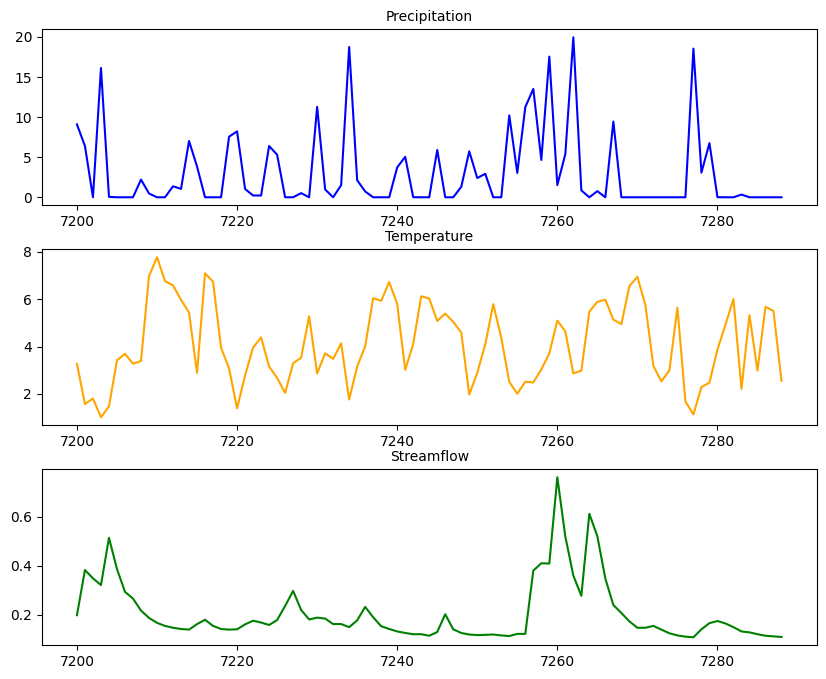

In [ ]:
plot_vars = ['Precipitation','Temperature','Streamflow']
colors = ['blue','orange','green']
titlesize = 10 

start_year = 0 
t_int = 30*360

start_day = start_year * 360; end_day = start_day+t_int-1
df_set = df.iloc[start_day:end_day].copy()
df_eval = df.iloc[end_day:end_day+1].copy()
t = df_set['day']

f, (ax1, ax2, ax3) = plt.subplots(len(plot_vars), 1, sharey=False,figsize = (10, 8),gridspec_kw={'height_ratios': [1, 1, 1]})
f.subplots_adjust(hspace=0.25)   # ← vertical spacing
ax1.plot(t, df_set[plot_vars[0]],color=colors[0])
ax1.set_title(plot_vars[0],fontsize=titlesize)
ax2.plot(t, df_set[plot_vars[1]],color=colors[1])
ax2.set_title(plot_vars[1],fontsize=titlesize)
ax3.plot(t, df_set[plot_vars[2]],color=colors[2])
ax3.set_title(plot_vars[2],fontsize=titlesize)

Text(0.5, 0, 'Temperature')

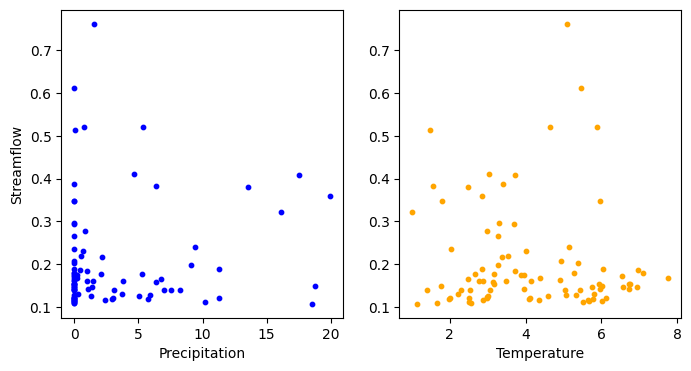

In [6]:
# scatter plot 
plotsize = 10
f, (ax1, ax2) = plt.subplots(1, 2, sharey=False,figsize = (8, 4))
f.subplots_adjust(hspace=0.25)   # ← vertical spacing
y = df_set[plot_vars[2]]
ax1.scatter(df_set[plot_vars[0]],y,c=colors[0],s=plotsize)
ax1.set_xlabel(plot_vars[0])
ax1.set_ylabel(plot_vars[2])
ax2.scatter(df_set[plot_vars[1]],y,c=colors[1],s=plotsize)
ax2.set_xlabel(plot_vars[1])


In [ ]:
# 2. Split the data into training and testing sets (e.g., 80% training, 20% testing) to evaluate the performance of your regression model. 
rtrain = .80
rtest = 1-rtrain

ndata = len(df)
ntrain = int(ndata*rtrain)
ntest = ndata-ntrain
print(ntrain,ntest,ndata,ntrain+ntest)
df_train = df.iloc[:ntrain]
df_test =  df.iloc[ntrain:]

8768 2192 10960 10960


In [77]:
# input data function
def make_LRmatrix(df,y_var,X_vars,win,targ_win=0):
    
    Xi = []
    Yi = []

    max_i = len(df) - (win + targ_win)
    for i in range(max_i):
        
        i_end = i + win
        i_targ = i_end + targ_win 
        y = df.iloc[i_targ][y_var]
        
        x = []
        for ftr in X_vars:
            f = np.array(df[ftr][i:i_end])
            x.append(f)
        x = np.hstack(x).reshape(1, -1)
        Xi.append(x)
        Yi.append(y)

    X = np.vstack(Xi)          # (n_samples, 180)
    y = np.array(Yi, float)    # (n_samples,)

    return(X,y)

In [78]:
# 3. Train a linear regression model on the training data and evaluate its performance on the testing data using appropriate metrics (e.g., R-squared, mean absolute error). Use a sample size where inputs are the previous 90 days of temperature and precipitation data, and the target variable is the streamflow on the 91st day. You may need to reshape your data accordingly to fit this format.
win = 90
targ = 0 
X_train,y_train = make_LRmatrix(df_train,'Streamflow',['Precipitation','Streamflow'],win,targ)
X_test,Q_obs = make_LRmatrix(df_test,'Streamflow',['Precipitation','Streamflow'],win,targ)

model = skl.linear_model.LinearRegression(fit_intercept=True)
model.fit(X_train,y_train)

Bn = model.coef_
B0 = model.intercept_
Q_pred = B0 + (X_test @ Bn)    

In [79]:
n = len(Q_obs)
resid = Q_obs - Q_pred
mdev = Q_obs - np.mean(Q_obs)

MSE = np.mean(resid**2)
R2 = 1 - np.sum(resid**2) / np.sum(mdev**2)

Q_obsLR = Q_obs.copy()
Q_modLR = Q_pred.copy()

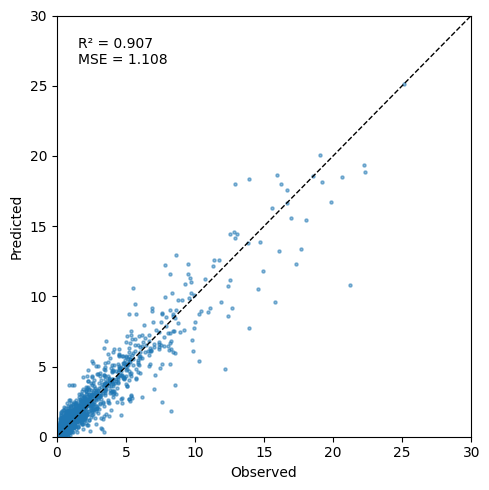

In [80]:
plt.figure(figsize=(5,5))

# scatter
plt.scatter(Q_obs, Q_pred,
            color='tab:blue',
            s=5,
            alpha=0.5)

# 1:1 reference line
lims = [
    min(Q_obs.min(), Q_pred.min()),
    max(Q_obs.max(), Q_pred.max())
]
plt.plot(lims, lims, 'k--', linewidth=1)

plt.xlabel('Observed')
plt.ylabel('Predicted')

# annotate metrics
plt.text(0.05, 0.95,
         f'R² = {R2:.3f}\nMSE = {MSE:.3f}',
         transform=plt.gca().transAxes,
         verticalalignment='top')
plt.xlim(0,30)
plt.ylim(0,30)
plt.tight_layout()


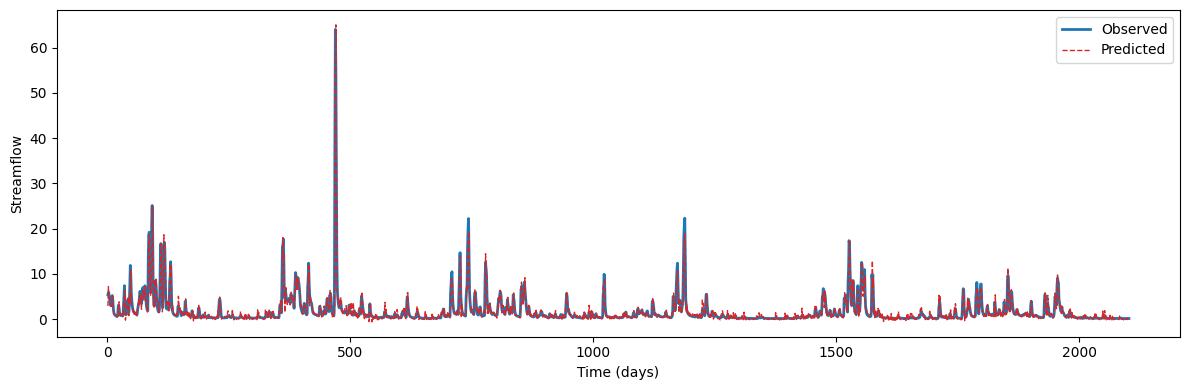

In [81]:
t_plot = np.arange(1,len(Q_obs)+1)
plt.figure(figsize=(12,4))

plt.plot(t_plot, Q_obs,
         color='tab:blue',
         linewidth=2,
         label='Observed')

plt.plot(t_plot, Q_pred,
         color='tab:red',
         linestyle='--',
         linewidth=1,
         label='Predicted')

plt.xlabel('Time (days)')
plt.ylabel('Streamflow')
plt.legend()
plt.tight_layout()

## Problem 3: Calibration of a simple hydrological model (25 points)
For this problem you will implement and calibrate a nonlinear hydrological model using the SCE optimization algorithm. The model is a conceptual bucket model expressed as a state-space ODE. The single state variable $S(t)$ represents the water storage in the catchment, and its evolution is governed by:

$$
\frac{dS}{dt} = P(t) - a \cdot \max(T(t),\, 0) - b \cdot S(t)^c
$$

Where:
- $S(t)$ is the catchment storage at time $t$ (the state variable).
- $P(t)$ is the precipitation at time $t$ (a forcing input).
- $T(t)$ is the temperature at time $t$ (a forcing input).
- $a \cdot \max(T(t),\, 0)$ represents evapotranspiration, assumed proportional to temperature when temperature is positive.
- $b \cdot S(t)^c$ is a nonlinear storage-discharge relationship that produces streamflow.

The predicted streamflow is then given by the output equation:

$$
Q(t) = b \cdot S(t)^c + d
$$

The parameters to calibrate are:
- $a$ — evapotranspiration coefficient
- $b$ — discharge coefficient
- $c$ — nonlinearity exponent of the storage-discharge relationship
- $d$ — baseflow offset

Perform the following steps:
1. Implement the model using scipy's `solve_ivp` (or `odeint`) function. You will need to define a function that computes $dS/dt$ given the current state $S$ and the forcing inputs $P(t)$ and $T(t)$. Since the forcing data is daily, you will need to interpolate $P$ and $T$ to evaluate them at arbitrary times requested by the ODE solver. You can use `scipy.interpolate.interp1d` for this purpose.
2. Define an objective function that computes the mean squared error between the observed streamflow and the model-predicted streamflow $Q(t)$ for a given set of parameters.
3. Use the SCE optimization algorithm to find the optimal parameters $a$, $b$, $c$, and $d$ that minimize the objective function using the SCE-UA algorithm as implemented with the `spotpy` library.

Note: you should use the spotpy documentation to help you implement the calibration: https://spotpy.readthedocs.io/en/latest/Calibration_with_SCE-UA/

In [14]:
Q_obs = np.array(df['Streamflow'])
T = np.array(df['Temperature'])
P = np.array(df['Precipitation'])
t = np.array(df['day'])
iT = interpolate.interp1d(t, T)
iP = interpolate.interp1d(t, P)

In [15]:
def dS_dt(t, y, a, b, c):
    S = y[0]
    P = float(iP(t))
    T = float(iT(t))
    S_eff = max(S, 0.0)
    dS_dt = P - a*max(T,0) - b*S_eff**c
    return [dS_dt]

def Q_calc(S,b,c,d):
    S_eff = np.maximum(S, 0.0)
    Q = b * (S_eff**c) + d 
    return(Q)

def calc_MSE(Q_obs,Q_mod):
    resid = Q_obs - Q_mod
    MSE = np.mean(resid**2)
    return(MSE)

In [ ]:
def run_mod(S0,pars,t):
    a = pars[0]; b = pars[1]; c = pars[2]; d = pars[3]
    sol = solve_ivp(dS_dt,((t[0], t[-1])),[S0],t_eval=t,args=(a,b,c))
    S_mod = sol.y[0]
    Q_mod = Q_calc(S_mod,b,c,d)

    return(Q_mod)


In [ ]:
S0_guess = 100
class spotpy_Qmod:
    def __init__(self, t, Q_obs, S0=S0_guess, obj_func=spotpy.objectivefunctions.mse):
        self.t = t
        self.Q_obs = Q_obs
        self.S0 = S0
        self.obj_func = obj_func

    def parameters(self):
        return spotpy.parameter.generate([
            spotpy.parameter.Uniform('a', low=0.0, high=1.0),
            spotpy.parameter.Uniform('b', low=0.0, high=1.0),
            spotpy.parameter.Uniform('c', low=0.5, high=3.0),
            spotpy.parameter.Uniform('d', low=0.0, high=10.0),])
    
    def simulation(self, vector):
        Q_mod = run_mod(self.S0, vector, self.t)
        return Q_mod
    def evaluation(self):
        return self.Q_obs
    def objectivefunction(self, simulation, evaluation):
        return self.obj_func(evaluation, simulation)

In [ ]:
setup = spotpy_Qmod(t=t, Q_obs=Q_obs, S0=100.0)
sampler = spotpy.algorithms.sceua(setup, dbname='sce_bucket', dbformat='csv')
rep = 100  
#sampler.sample(rep, ngs=7, kstop=3, peps=0.1, pcento=0.1)

Initializing the  Shuffled Complex Evolution (SCE-UA) algorithm  with  100  repetitions
The objective function will be minimized
Starting burn-in sampling...
1 of 100, minimal objective function=22.3114, time remaining: 00:04:57
Initialize database...
['csv', 'hdf5', 'ram', 'sql', 'custom', 'noData']
* Database file 'sce_bucket.csv' created.
2 of 100, minimal objective function=6.62836, time remaining: 00:05:13
3 of 100, minimal objective function=6.62836, time remaining: 00:06:11
4 of 100, minimal objective function=6.62836, time remaining: 00:06:23
5 of 100, minimal objective function=6.62836, time remaining: 00:06:40
6 of 100, minimal objective function=6.62836, time remaining: 00:06:57
7 of 100, minimal objective function=6.62836, time remaining: 00:07:49
8 of 100, minimal objective function=6.62836, time remaining: 00:07:57
9 of 100, minimal objective function=6.62836, time remaining: 00:08:25
10 of 100, minimal objective function=6.62836, time remaining: 00:08:15
11 of 100, minim

In [136]:
results = spotpy.analyser.load_csv_results('sce_bucket_1')
best_index = np.argmin(results['like1'])
best_row = results[best_index]
print("Best MSE:", results['like1'][best_index])
pars_opt = best_row[['para','parb','parc','pard']]
print("optimized parameters:")
print(pars_opt)


Best MSE: 5.4088473
optimized parameters:
(0.7236104, 0.57379633, 0.81244373, 0.37846428)








## Problem 4: Comparison of linear regression and SCE optimization (25 points)
Compare the performance of the linear regression model and the SCE optimization algorithm for predicting streamflow from the previous problems based on the same dataset. Perform the following steps:

1. Calculate the Overall NSE (Nash-Sutcliffe Efficiency) for both models on the testing data. The NSE is defined as:
$$
NSE = 1 - \frac{\sum_{i=1}^{n} (Q_{obs,i} - Q_{pred,i})^2}{\sum_{i=1}^{n} (Q_{obs,i} - \bar{Q}_{obs})^2}
$$
Where $Q_{obs,i}$ is the observed streamflow, $Q_{pred,i}$ is the predicted streamflow, and $\bar{Q}_{obs}$ is the mean of the observed streamflow.
2. Create a figure that compares the observed streamflow with the predictions from both models over time. Include appropriate labels, legends, and titles to clearly distinguish between the observed data and the predictions from the linear regression and SCE models.
3. Discuss the results: Which model performs better in terms of NSE? What are the strengths and weaknesses of each model? How might you improve the performance of each model? 




In [126]:
def NSE(obs,pred):
    resid = obs - pred
    var = obs - np.mean(obs)

    nse = 1 - (sum(resid**2) / sum(var**2)) 
    return(nse)

def MSE(obs, pred):
    return np.mean((obs - pred)**2)

def R2(obs, pred):
    resid = obs - pred
    dev = obs - np.mean(obs)
    return 1 - np.sum(resid**2) / np.sum(dev**2)


In [132]:
Q_modSCE = run_mod(S0_guess,pars_opt,t[ntrain+win:])

NSE_LR  = round(NSE(Q_modLR,  Q_obsLR),4)
NSE_SCE = round(NSE(Q_modSCE, Q_obsLR),4)

MSE_LR  = round(MSE(Q_modLR,  Q_obsLR),4)
MSE_SCE = round(MSE(Q_modSCE, Q_obsLR),4)

R2_LR   = round(R2(Q_modLR,  Q_obsLR),4)
R2_SCE  = round(R2(Q_modSCE, Q_obsLR),4)

METRICS: NSE, MSE, R2
Linear Regression: 0.8996, 1.108, 0.8996
SCE-UA: 0.5629, 7.0434, 0.5629


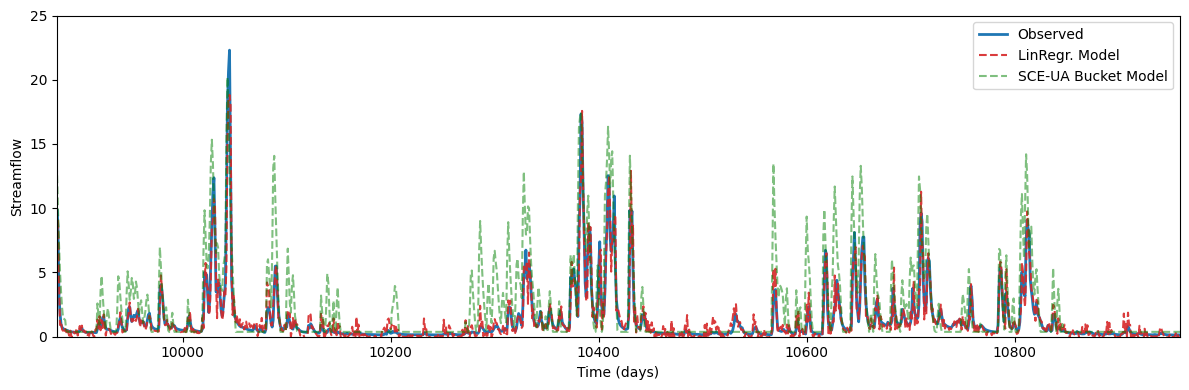

In [135]:
plot_window = 3 # years 
t_plot = t[ntrain+win:]
plt.figure(figsize=(12,4))

t_end = t_plot[-1]

print('METRICS: NSE, MSE, R2')
print(f'Linear Regression: {NSE_LR}, {MSE_LR}, {R2_LR}')
print(f'SCE-UA: {NSE_SCE}, {MSE_SCE}, {R2_SCE}')

plt.plot(t_plot, Q_obsLR,
         color='tab:blue',
         linestyle='-',
         linewidth=2,
         label='Observed')

plt.plot(t_plot, Q_modLR,
         color='tab:red',
         linestyle='--',
         linewidth=1.5,
         alpha=0.9,
         label='LinRegr. Model')

plt.plot(t_plot, Q_modSCE,
         color='green',
         linestyle='--',
         linewidth=1.5,
         alpha=0.5,
         label='SCE-UA Bucket Model')

plt.xlabel('Time (days)')
plt.ylabel('Streamflow')
plt.ylim(0,25)
plt.xlim(t_end-(360*plot_window),t_end)
plt.legend()
plt.tight_layout()

3. Discuss the results: 

Which model performs better in terms of NSE? 
- the linear regression model performed better in terms of NSE, where it had ~0.90 and the SCE-UA at 0.56.

What are the strengths and weaknesses of each model? 
- the linear regression model is very consistent with the data and low error. However this regression model requires a large amount of input data (previous 90 days) to predict one day forward. Therefore it is limited in it's application. While the bucket model optimized by the SCE-UA algorithm had lower performance scores, this model has interpretibility. Because the internal variables capture and model the states and interactions influencing the system, it allows for further physical insight about the components influencing streamflow. For the LR, only streamflow is shown, and provides minimal physical insight. 

How might you improve the performance of each model? 
- The SCE-UA could likely be significantly improved from the methods applied in this homework by identifying refined fitting coefficient boundaries, improving the estimation of the initial storage, and increasing the number of iterations and tuning parameters for the optimization. Insight into improving the fitting coefficient boundaries could be done manually, by assessing the ranges of input data, and units, as a refined estimation. Sensitivity analysis of the parameters could be run using an ensemble. To imrpove the initial storage, after "reasonable" parameters are found, where prediction is sufficient, a spin-up could be run on the first X years of data until storage reaches a steady state, and this storage could then be implemented for optimize for the coefficients. 
- For the linear regression model, the fit could be improved by possible transformations to the input data which may emphasize conditions that deviate from a linear trend. For example, adding an exponent to temperature to possibly capture a non-linear ET loss. Furthermore, another data type which impacts streamflow could also be incorporated, such as soil moisture. 